# Human islets data QC and preprocessing

This notebook was run with scanpy v1.4

In [1]:
import scanpy.api as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri
import scrublet as scr
import os
from scipy.sparse import csr_matrix

%matplotlib inline
%load_ext rpy2.ipython

/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [ ]:
# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()

sc.settings.verbosity = 3
sc.set_figure_params()
sc.logging.print_versions()

## Load data - Cellranger output files

In [9]:
# Cellranger output data Data files
sample_strings = ['HI_22', 'HI_24', 'HI_61', 'HI_63', 'HI_74']

In [ ]:
adata_dict = {}

for smp in sample_strings:
    data_file = f'./data/{smp}/matrix.mtx' # make sure to adapt path to folder with CellRanger Output
    barcode_file = f'./data/{smp}/barcodes.tsv'
    gene_file = f'./data/{smp}/genes.tsv'

    adata = sc.read(data_file, cache=True).transpose()   
    adata.var_names = np.genfromtxt(gene_file, dtype=str)[:, 1]
    adata.var['gene_id'] = np.genfromtxt(gene_file, dtype=str)[:, 0]
    adata.obs_names = np.genfromtxt(barcode_file, dtype=str)
    adata.obs['donor'] = smp.split('_')[1]
    adata.obs['sample'] = smp
    
    adata.var_names_make_unique()
    
    adata_dict[smp] = adata

In [28]:
adata22 = adata_dict['HI_22'].copy()
adata24 = adata_dict['HI_24'].copy()
adata61 = adata_dict['HI_61'].copy()
adata63 = adata_dict['HI_63'].copy()
adata74 = adata_dict['HI_74'].copy()

## Load data - GEO h5ad-file

In [ ]:
adata22 = adata[adata.obs['sample']=='22'].copy()
adata24 = adata[adata.obs['sample']=='24'].copy()
adata61 = adata[adata.obs['sample']=='61'].copy()
adata63 = adata[adata.obs['sample']=='63'].copy()
adata74 = adata[adata.obs['sample']=='74'].copy()

## Quality Control

In [ ]:
def add_qc_metrics(adata):
    # Quality control - calculate QC covariates
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(1)
    # fraction of mt-encoded genes per cell type
    mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
    adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']
    return adata

### HI_22

In [ ]:
adata22 = add_qc_metrics(adata22)

#### doublets

In [227]:
counts_matrix = adata22.X.copy()

In [228]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

In [229]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 39.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.1%
Elapsed time: 25.8 seconds


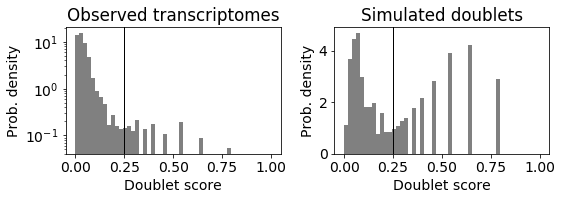

In [307]:
scrub.plot_histogram();

In [230]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 43.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.7%


array([False, False, False, ..., False, False, False])

In [237]:
adata22.obs['doublet'] = doublet_scores

#### Cell filtering

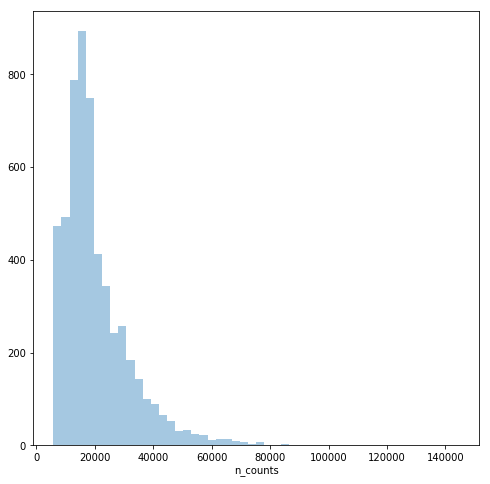

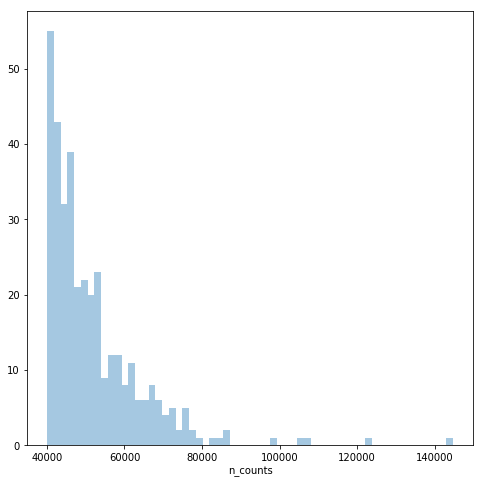

In [10]:
#Thresholding decision: counts
p3 = sb.distplot(adata22.obs['n_counts'], kde=False)
plt.show()
p4 = sb.distplot(adata22.obs['n_counts'][adata22.obs['n_counts']>40000], kde=False, bins=60)
plt.show()

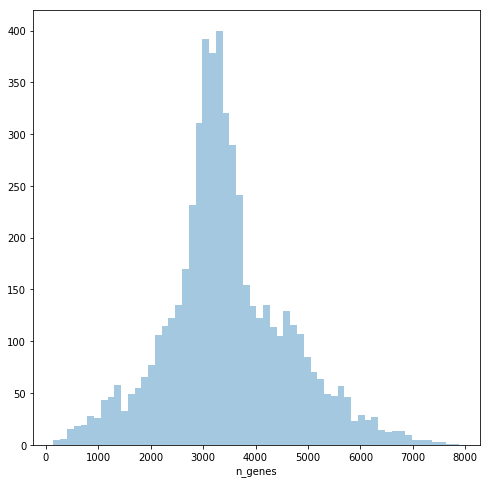

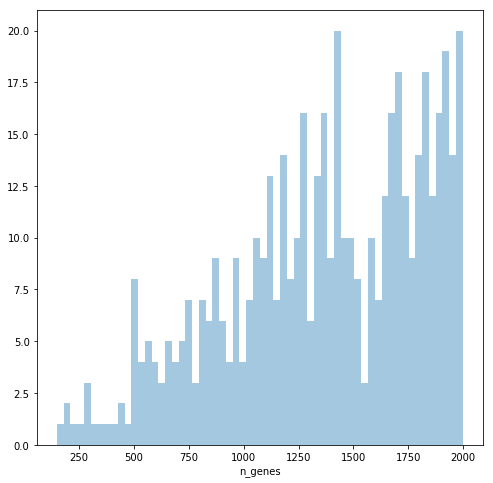

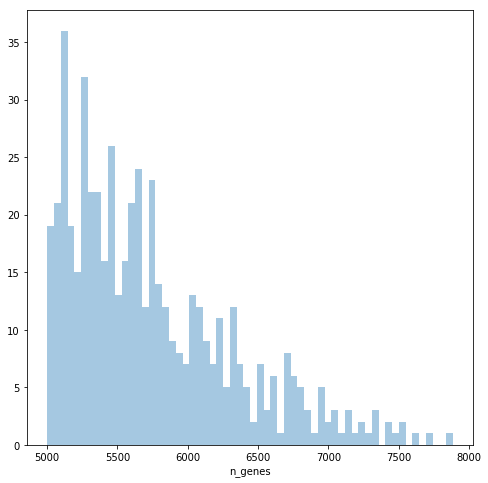

In [11]:
#Thresholding decision: genes
p5 = sb.distplot(adata22.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata22.obs['n_genes'][adata22.obs['n_genes']<2000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata22.obs['n_genes'][adata22.obs['n_genes']>5000], kde=False, bins=60)
plt.show()

In [35]:
# FILTER PARAMETERS HI_22
print('Total number of cells: {:d}'.format(adata22.n_obs))

#Filter out counts over 40000
sc.pp.filter_cells(adata22, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata22.n_obs))

adata22 = adata22[adata22.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata22.n_obs))

#Filter out genes under 1600
sc.pp.filter_cells(adata22, min_genes = 1600)
print('Number of cells after gene filter: {:d}'.format(adata22.n_obs))

Total number of cells: 5476
filtered out 361 cells that havemore than 40000 counts
Number of cells after max count filter: 5115
Number of cells after MT filter: 4902
filtered out 241 cells that haveless than 1600 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 4661


### HI_24

In [ ]:
adata24 = add_qc_metrics(adata24)

#### doublets

In [132]:
scrub = scr.Scrublet(adata24.X.copy(), expected_doublet_rate=0.06)

In [133]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 46.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.9%
Elapsed time: 25.8 seconds


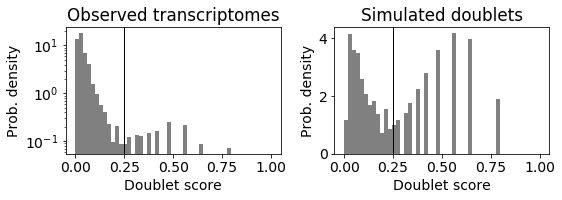

In [320]:
scrub.plot_histogram();

In [134]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 48.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.1%


array([False, False, False, ..., False, False, False])

In [140]:
adata24.obs['doublet']=doublet_scores

#### Cell filtering

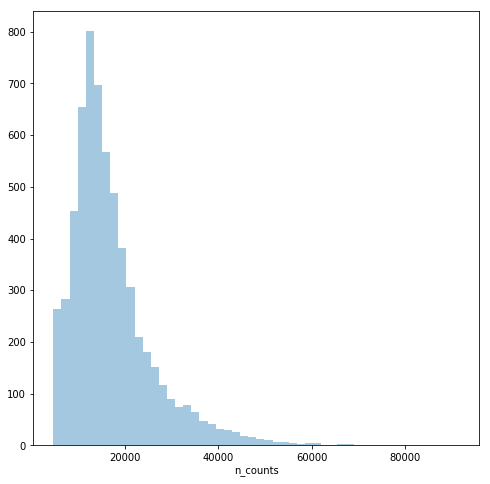

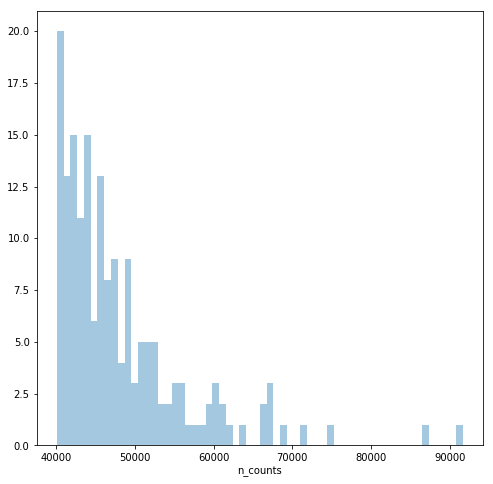

In [34]:
#Thresholding decision: counts
p3 = sb.distplot(adata24.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata24.obs['n_counts'][adata24.obs['n_counts']>40000], kde=False, bins=60)
plt.show()

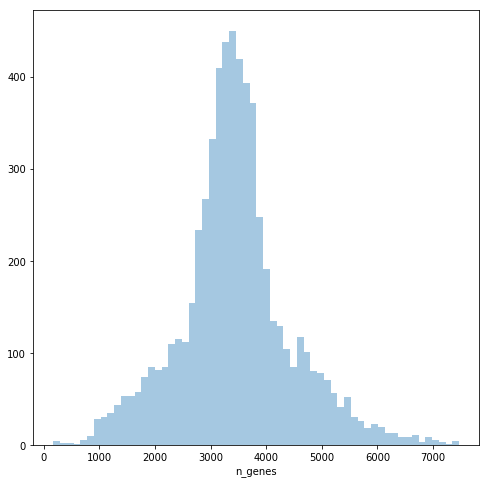

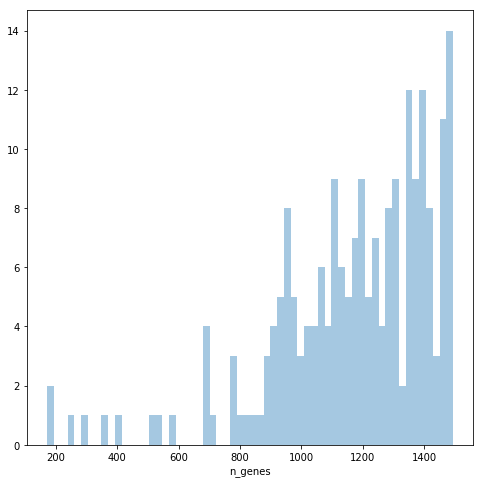

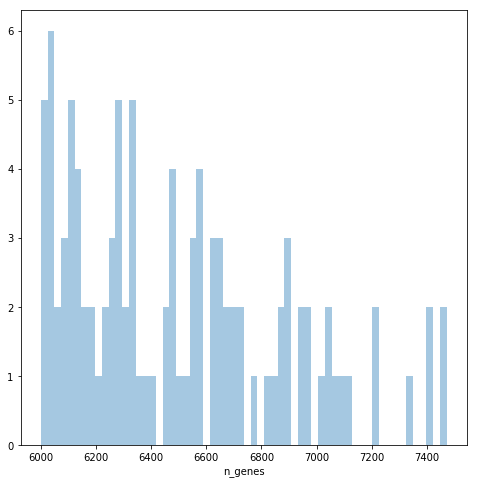

In [35]:
#Thresholding decision: genes
p5 = sb.distplot(adata24.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata24.obs['n_genes'][adata24.obs['n_genes']<1500], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata24.obs['n_genes'][adata24.obs['n_genes']>6000], kde=False, bins=60)
plt.show()

In [30]:
# FILTER PARAMETERS HI_24

print('Total number of cells: {:d}'.format(adata24.n_obs))

#Filter out counts over 59000
sc.pp.filter_cells(adata24, max_counts = 59000)
print('Number of cells after max count filter: {:d}'.format(adata24.n_obs))

adata24 = adata24[adata24.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata24.n_obs))

#Filter out genes under 1000
sc.pp.filter_cells(adata24, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata24.n_obs))

#Filter out genes over 6600
sc.pp.filter_cells(adata24, max_genes = 6600)
print('Number of cells after gene filter: {:d}'.format(adata24.n_obs))

Total number of cells: 6132
filtered out 19 cells that havemore than 59000 counts
Number of cells after max count filter: 6113
Number of cells after MT filter: 5838
filtered out 24 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 5814
filtered out 24 cells that havemore than 6600 genes expressed
Number of cells after gene filter: 5790


### HI_61

In [ ]:
adata61 = add_qc_metrics(adata61)

#### doublets

In [165]:
scrub = scr.Scrublet(adata61.X.copy(), expected_doublet_rate=0.06)

In [166]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.4%
Elapsed time: 26.5 seconds


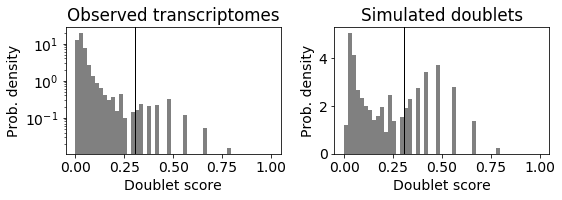

In [335]:
scrub.plot_histogram();

In [167]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 3.4%
Estimated detectable doublet fraction = 42.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.9%


array([False, False, False, ..., False, False, False])

In [171]:
adata61.obs['doublet'] = doublet_scores

#### Cell Filtering

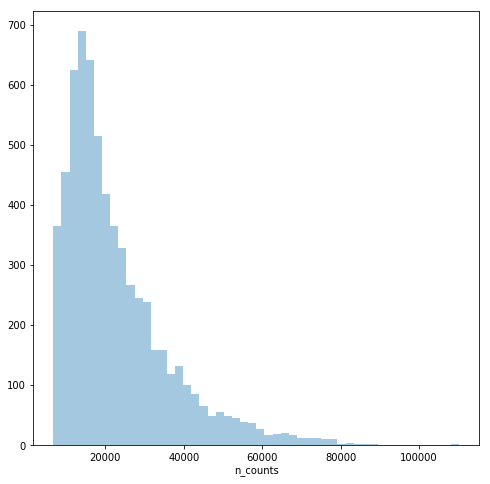

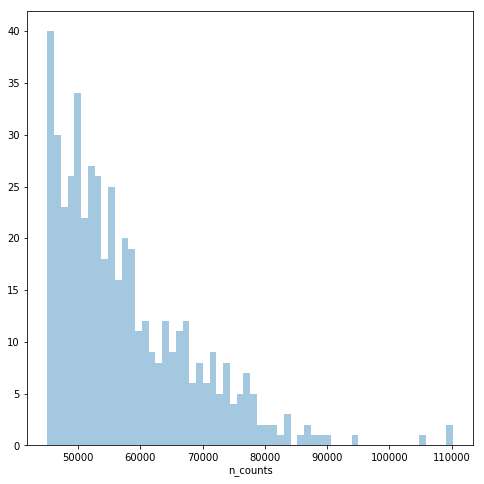

In [31]:
#Thresholding decision: counts
p3 = sb.distplot(adata61.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata61.obs['n_counts'][adata61.obs['n_counts']>45000], kde=False, bins=60)
plt.show()

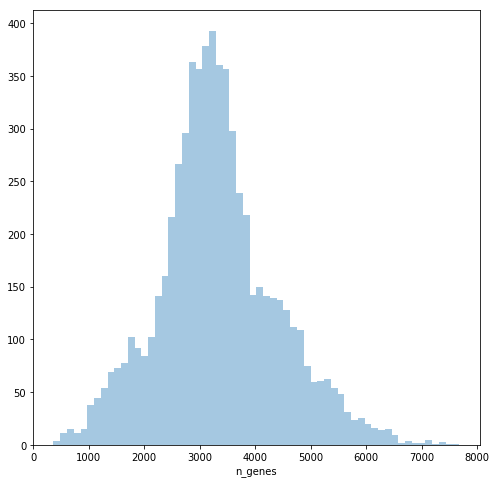

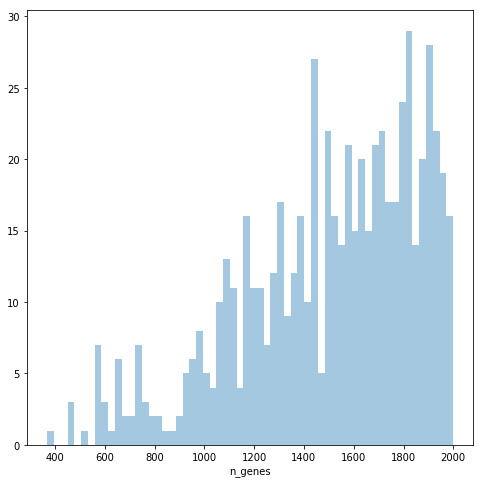

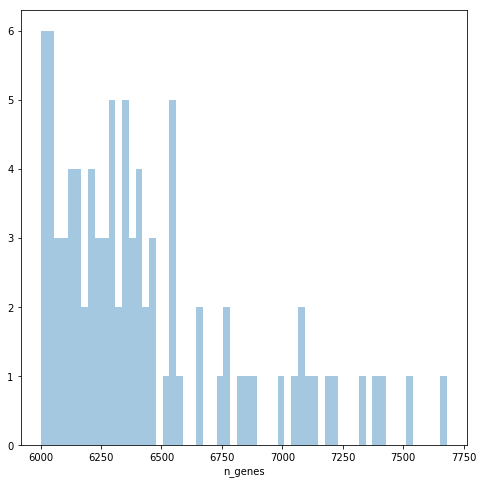

In [34]:
#Thresholding decision: genes
p5 = sb.distplot(adata61.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata61.obs['n_genes'][adata61.obs['n_genes']<2000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata61.obs['n_genes'][adata61.obs['n_genes']>6000], kde=False, bins=60)
plt.show()

In [31]:
# FILTER PARAMETERS HI_61

print('Total number of cells: {:d}'.format(adata61.n_obs))

#Filter out counts over 60000
sc.pp.filter_cells(adata61, max_counts = 60000)
print('Number of cells after max count filter: {:d}'.format(adata61.n_obs))


adata61 = adata61[adata61.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata61.n_obs))

#Filter out genes under 1000
sc.pp.filter_cells(adata61, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata61.n_obs))

#Filter out genes over 6500
sc.pp.filter_cells(adata61, max_genes = 6500)
print('Number of cells after gene filter: {:d}'.format(adata61.n_obs))

Total number of cells: 6427
filtered out 160 cells that havemore than 60000 counts
Number of cells after max count filter: 6267
Number of cells after MT filter: 6226
filtered out 59 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 6167
filtered out 3 cells that havemore than 6500 genes expressed
Number of cells after gene filter: 6164


### HI_63

In [ ]:
adata63 = add_qc_metrics(adata63)

#### doublets

In [177]:
scrub = scr.Scrublet(adata63.X.copy(), expected_doublet_rate=0.06)

In [178]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 41.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.2%
Elapsed time: 19.7 seconds


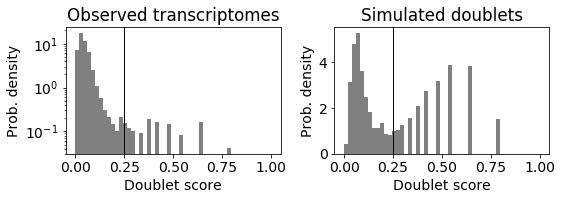

In [361]:
scrub.plot_histogram();

In [179]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 45.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.1%


array([False, False, False, ..., False, False, False])

In [183]:
adata63.obs['doublet'] = doublet_scores

#### Cell filtering

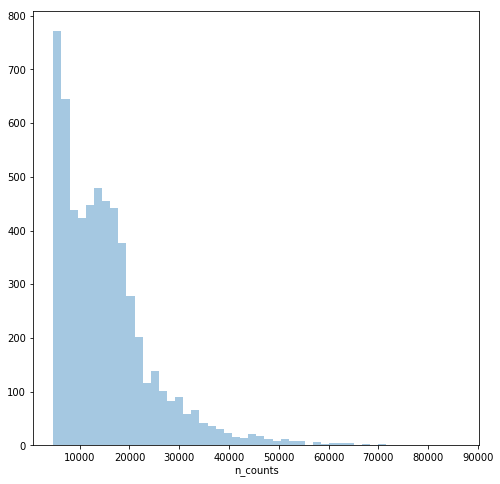

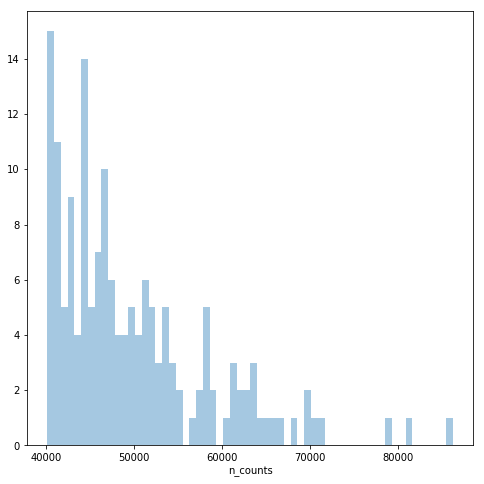

In [38]:
#Thresholding decision: counts
p3 = sb.distplot(adata63.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata63.obs['n_counts'][adata63.obs['n_counts']>40000], kde=False, bins=60)
plt.show()

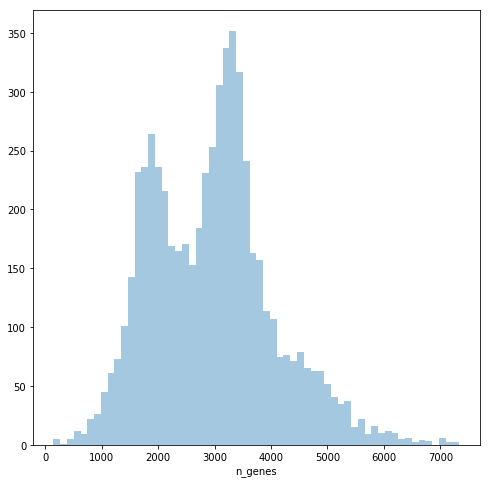

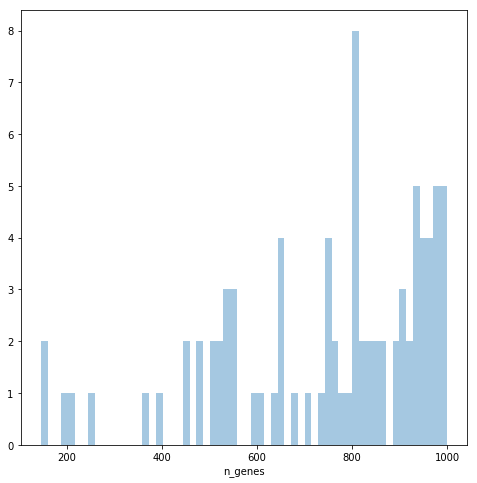

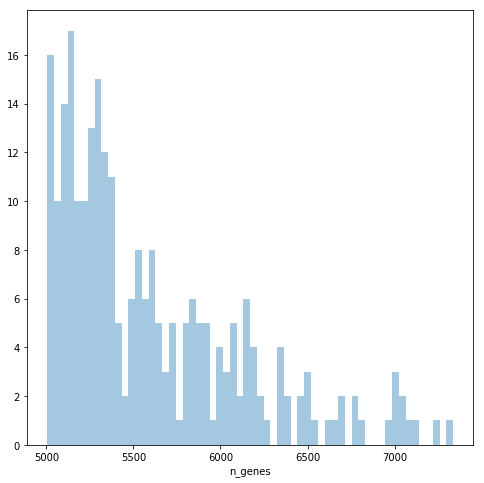

In [41]:
#Thresholding decision: genes
p5 = sb.distplot(adata63.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata63.obs['n_genes'][adata63.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata63.obs['n_genes'][adata63.obs['n_genes']>5000], kde=False, bins=60)
plt.show()

In [32]:
# FILTER PARAMETERS HI_63

print('Total number of cells: {:d}'.format(adata63.n_obs))

#Filter out counts over 55000
sc.pp.filter_cells(adata63, max_counts = 55000)
print('Number of cells after max count filter: {:d}'.format(adata63.n_obs))


adata63 = adata63[adata63.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata63.n_obs))

#Filter out genes under 900
sc.pp.filter_cells(adata63, min_genes = 900)
print('Number of cells after gene filter: {:d}'.format(adata63.n_obs))

#Filter out genes over 6500
sc.pp.filter_cells(adata63, max_genes = 6500)
print('Number of cells after gene filter: {:d}'.format(adata63.n_obs))

Total number of cells: 5888
filtered out 33 cells that havemore than 55000 counts
Number of cells after max count filter: 5855
Number of cells after MT filter: 5542
filtered out 29 cells that haveless than 900 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 5513
filtered out 6 cells that havemore than 6500 genes expressed
Number of cells after gene filter: 5507


### HI_74

In [ ]:
adata74 = add_qc_metrics(adata74)

#### doublets

In [189]:
scrub = scr.Scrublet(adata74.X.copy(), expected_doublet_rate=0.06)

In [190]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 5.0%
Estimated detectable doublet fraction = 51.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.7%
Elapsed time: 42.3 seconds


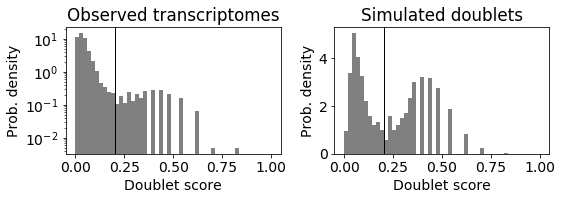

In [349]:
scrub.plot_histogram();

In [191]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 47.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.3%


array([False, False, False, ..., False, False, False])

In [195]:
adata74.obs['doublet'] = doublet_scores

#### Cell filtering

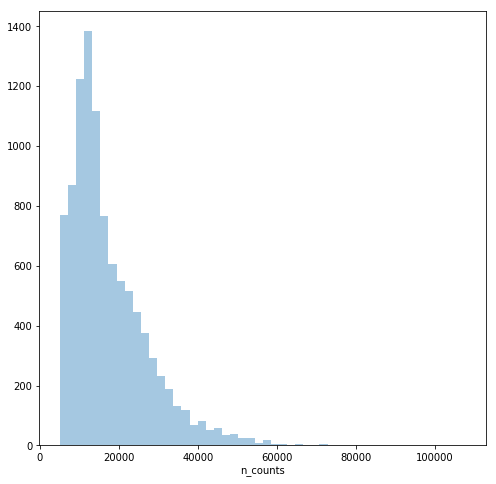

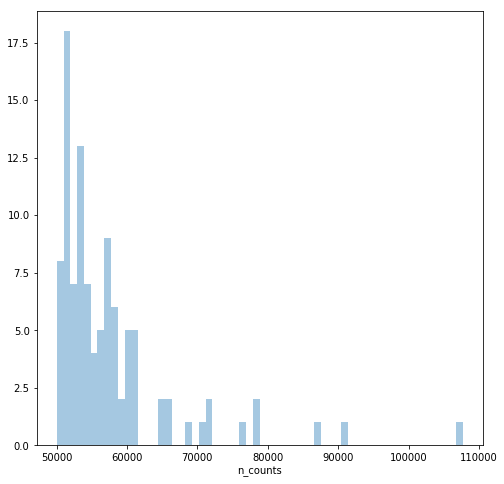

In [49]:
#Thresholding decision: counts
p3 = sb.distplot(adata74.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata74.obs['n_counts'][adata74.obs['n_counts']>50000], kde=False, bins=60)
plt.show()

#Filter out counts over 58000

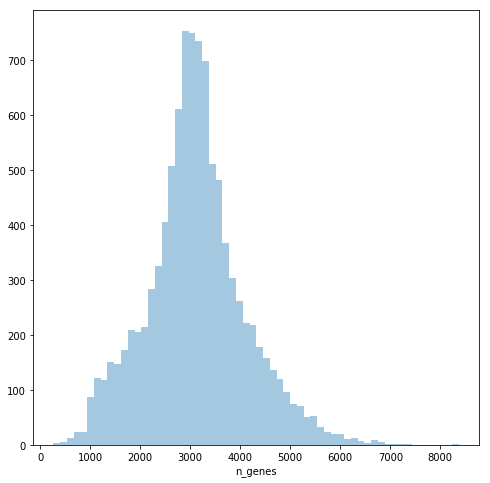

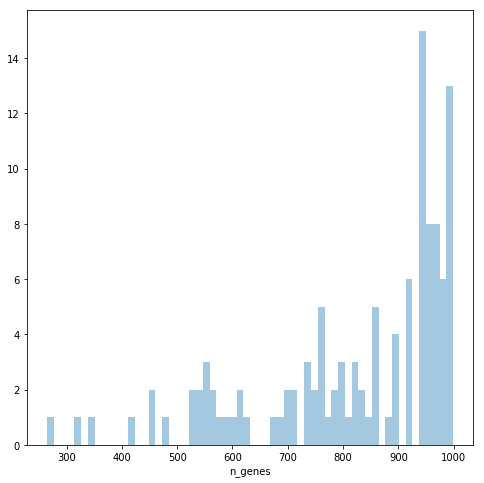

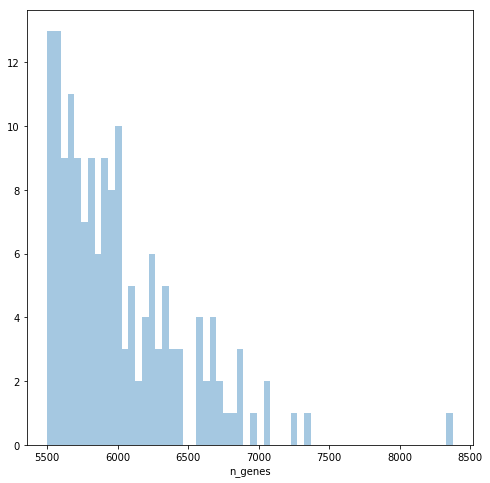

In [52]:
#Thresholding decision: genes
p5 = sb.distplot(adata74.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata74.obs['n_genes'][adata74.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata74.obs['n_genes'][adata74.obs['n_genes']>5500], kde=False, bins=60)
plt.show()

#Filter out genes under 1000
#Filter out genes over 6000

In [33]:
# FILTER PARAMETERS HI_74

print('Total number of cells: {:d}'.format(adata74.n_obs))

#Filter out counts over 58000
sc.pp.filter_cells(adata74, max_counts = 58000)
print('Number of cells after max count filter: {:d}'.format(adata74.n_obs))


adata74 = adata74[adata74.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata74.n_obs))

#Filter out genes under 1000
sc.pp.filter_cells(adata74, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata74.n_obs))

#Filter out genes over 6000
sc.pp.filter_cells(adata74, max_genes = 6000)
print('Number of cells after gene filter: {:d}'.format(adata74.n_obs))

Total number of cells: 10021
filtered out 28 cells that havemore than 58000 counts
Number of cells after max count filter: 9993
Number of cells after MT filter: 9919
filtered out 105 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 9814
filtered out 38 cells that havemore than 6000 genes expressed
Number of cells after gene filter: 9776


## Concatenate donors

In [69]:
#Concatenate different QQ_adatas in adata for normalization
adata = adata22.concatenate(adata24, adata61, adata63, adata74, batch_key='sample', batch_categories=['22', '24', '61', '63', '74'])

## Filter genes

In [83]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 20598
filtered out 812 genes that are detectedin less than 20 cells
Number of genes after cell filter: 19786


## Normalization

In [6]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:33.18) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:28.41) --> found 15 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


In [8]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [10]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [11]:
#Delete adata_pp
del adata_pp

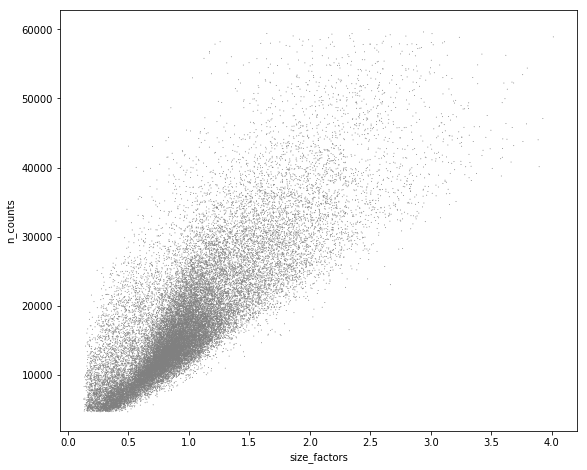

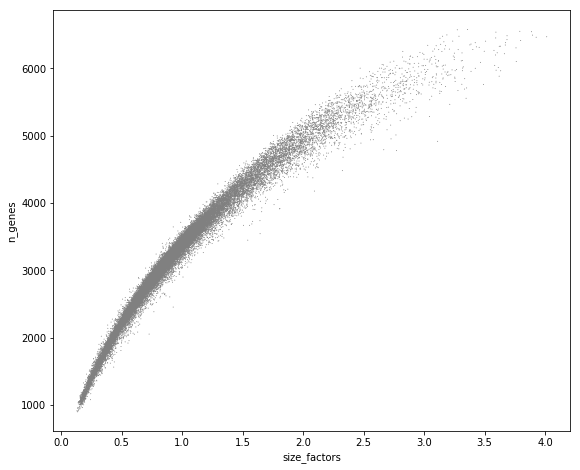

In [9]:
# Visualize the estimated size factors

adata.obs['size_factors'] = size_factors
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

In [13]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [14]:
#Normalize and log transform data
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)

In [15]:
#adata.raw = adata

## Batch Correction

In [4]:
#Before batch correction - Quick selection of HVGs and UMAP calculation
sc.pp.filter_genes_dispersion(adata, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/u

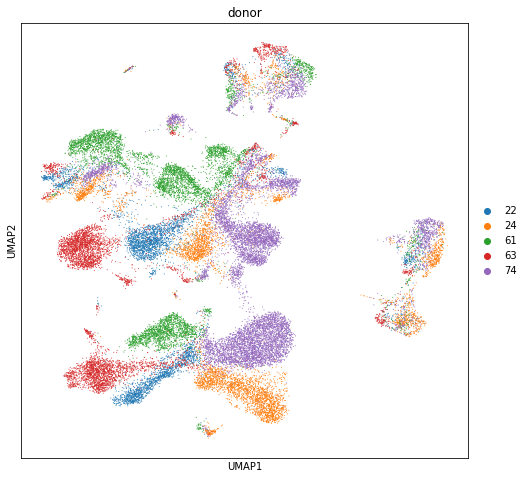

In [5]:
sc.pl.umap(adata, color='donor')

In [6]:
# Use Combat
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 5 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_comb

Adjusting data



/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packa

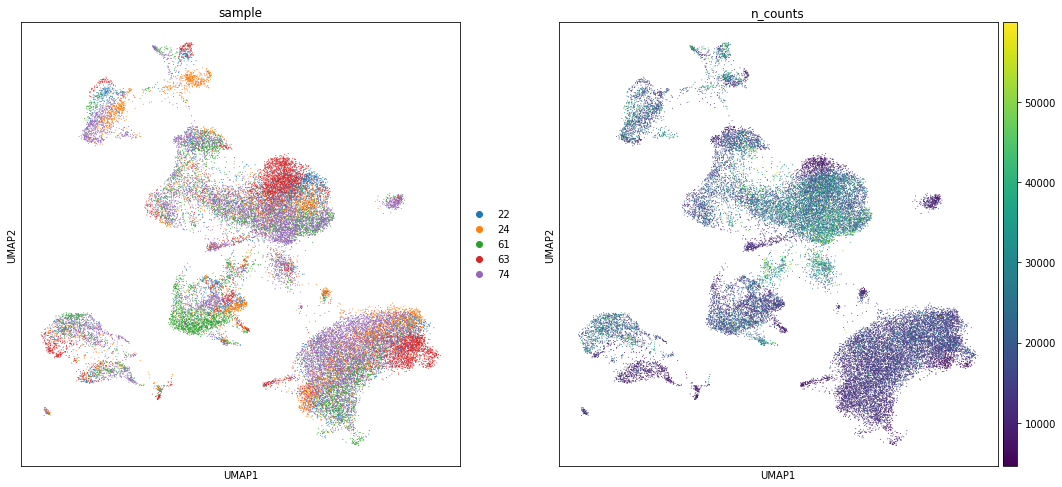

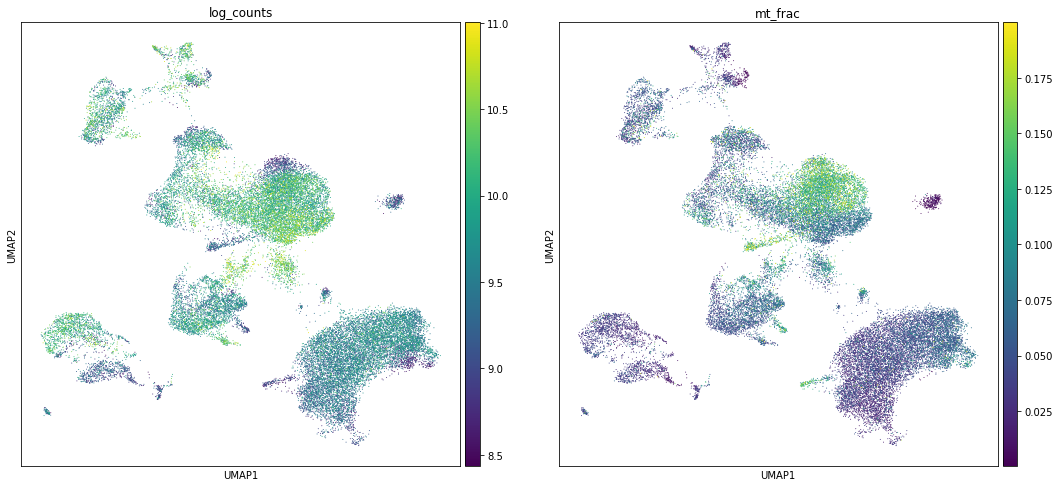

In [8]:
sc.pp.filter_genes_dispersion(adata, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['sample', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

In [ ]:
# set zero-values to zero again after correction to avoid spurious effects around zero introduced by the correction and ensure that count matrix is sparse
adata.X[adata.layers['counts']==0] = 0

In [ ]:
adata.X = csr_matrix(adata.X)

### Save preprocessed adata

In [ ]:
adata.write('./data/adata_human_norm.h5ad')